In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
import torch, numpy as np
from minai.core import *
from datasets import load_dataset
from torch.utils.data import DataLoader
from torch import nn, tensor
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

In [3]:
torch.manual_seed(42)
np.random.seed(42)

## Prepare

In [4]:
model_id = 'meta-llama/Llama-2-7b-hf'
# model_id = 'gpt2-medium'
llama_base = AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    low_cpu_mem_usage=True,
    torch_dtype=torch.bfloat16,
    use_cache=False
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [6]:
tokenizer.pad_token = tokenizer.eos_token

In [7]:
dataset = load_dataset("knowrohit07/know_sql", revision='f33425d13f9e8aab1b46fa945326e9356d6d5726', split="train")

In [8]:
def to_text(x):
    x['text'] = 'Context: ' + x['context'] + '\nQuestion: ' + x['question'] + '\nAnswer: ' + x['answer']
    # tokenize here?
    return x

def tok(x):
    x = tokenizer(x['text'], padding='longest')
    x['labels'] = deepcopy(x['input_ids'])
    return x

In [9]:
lf = nn.CrossEntropyLoss()

In [10]:
dataset = dataset.shuffle(42).map(to_text).filter(lambda x:len(x['text'])<380)

In [11]:
train_dataset = dataset.select(range(0, len(dataset)-200)) # Subset for testing
eval_dataset = dataset.select(range(len(dataset)-200, len(dataset))) # And only 200 eval samples
train_dataset

Dataset({
    features: ['context', 'answer', 'question', 'text'],
    num_rows: 76119
})

In [12]:
# Reorder by length

In [13]:
# Collate function for DataLoaders
def collate_fn(examples, debug=False):
    batch_size = len(examples)
    input_ids = tokenizer([e['text'] for e in examples], return_tensors='pt', padding=True)['input_ids']
    batch = (input_ids[:, :-1], input_ids[:, 1:]) # input_ids, labels
    # For HF style: batch = {'input_ids': input_ids[:, :-1], 'labels': input_ids[:, 1:]}
    return batch

In [14]:
batch_size = 64

In [15]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=True,
)

In [16]:
eval_dataloader = DataLoader(
    eval_dataset,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=False,
)

In [17]:
xb, yb = next(iter(train_dataloader))
xb.shape, yb.shape

(torch.Size([64, 115]), torch.Size([64, 115]))

In [18]:
tokenizer.decode(xb[0])

'<s> Context: CREATE TABLE table_name_74 (week VARCHAR, attendance INTEGER)\nQuestion: How many weeks had an attendance of over 68,000?\nAnswer: SELECT COUNT(week) FROM table_name_74 WHERE attendance > 68 OFFSET 000</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s>'

In [19]:
tokenizer.decode(yb[0])

'Context: CREATE TABLE table_name_74 (week VARCHAR, attendance INTEGER)\nQuestion: How many weeks had an attendance of over 68,000?\nAnswer: SELECT COUNT(week) FROM table_name_74 WHERE attendance > 68 OFFSET 000</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s>'

# Training

In [20]:
dls = DataLoaders(train_dataloader, eval_dataloader)

In [21]:
def loss_fn(x, y):
    return torch.nn.functional.cross_entropy(x.view(-1, x.shape[-1]), y.view(-1))

In [22]:
# from peft import get_peft_config, get_peft_model, LoraConfig, TaskType

# peft_config = LoraConfig(
#     task_type=TaskType.CAUSAL_LM, inference_mode=False, r=32, lora_alpha=16, lora_dropout=0.1,
#     target_modules=[l+"_proj" for l in ["k", 'v', "q", "o", "gate", "up", "down"]]
# )
# model = get_peft_model(llama_base, peft_config)

In [23]:
from torch import optim

In [24]:
prog = ProgressCB(plot=True)
cbs = [DeviceCB(), MetricsCB()]

In [25]:
# for n,o in llama_base.named_parameters():
#     # careful - this makes all activations 32bit!
#     if 'norm' in n: o.data = o.float()

In [26]:
model = llama_base

In [27]:
model.model.embed_tokens.weight.requires_grad_(False);

In [28]:
# Freeze the base model
for param in llama_base.parameters(): param.requires_grad = False

# Unfreeze final layer (lm_head_)
for param in llama_base.lm_head.parameters(): param.requires_grad = True
for param in llama_base.model.layers[8:].parameters(): param.requires_grad = True

In [29]:
#|export
def _get_inp(b, n_inp, inp_nm):
    if inp_nm is not None: return [b[inp_nm]]
    return b[:n_inp]

def _get_lbl(b, n_inp, lbl_nm):
    if lbl_nm is not None: return [b[lbl_nm]]
    return b[n_inp:]

def _get_preds(b, preds_nm):
    return b if preds_nm is None else getattr(b, preds_nm)

In [30]:
#|export
class TrainLearner(Learner):
    def __init__(self, model, dls, loss_func, lr=None, cbs=None, opt_func=torch.optim.SGD, epoch_sz=None,
                 n_inp=1, inp_nm=None, lbl_nm=None, preds_nm=None):
        super().__init__(model, dls, loss_func, lr, cbs, opt_func=opt_func, epoch_sz=epoch_sz)
        self.n_inp,self.inp_nm,self.lbl_nm,self.preds_nm = n_inp,inp_nm,lbl_nm,preds_nm

    def predict(self):
        inps = _get_inp(self.batch, self.n_inp, self.inp_nm)
        self.preds = self.model(*inps)

    def get_loss(self):
        lbls = _get_lbl(self.batch, self.n_inp, self.lbl_nm)
        preds = _get_preds(self.preds, self.preds_nm)
        self.loss = self.loss_func(preds, *lbls)

    def backward(self): self.loss.backward()
    def step(self): self.opt.step()
    def zero_grad(self): self.opt.zero_grad()

In [31]:
#|export
class TrainCB(Callback):
    def __init__(self, n_inp=1, inp_nm=None, lbl_nm=None, preds_nm=None):
        self.n_inp = n_inp
        self.n_inp,self.inp_nm,self.lbl_nm,self.preds_nm = n_inp,inp_nm,lbl_nm,preds_nm

    def predict(self, learn):
        inps = _get_inp(learn.batch, self.n_inp, self.inp_nm)
        learn.preds = learn.model(*inps)

    def get_loss(self, learn):
        lbls = _get_lbl(learn.batch, self.n_inp, self.lbl_nm)
        preds = _get_preds(learn.preds, self.preds_nm)
        learn.loss = learn.loss_func(preds, *lbls)

    def backward(self, learn): learn.loss.backward()
    def step(self, learn): learn.opt.step()
    def zero_grad(self, learn): learn.opt.zero_grad()

In [32]:
#|export
class MomentumLearner(TrainLearner):
    def __init__(self, model, dls, loss_func, lr=None, cbs=None, opt_func=torch.optim.SGD, epoch_sz=None,
                 n_inp=1, inp_nm=None, lbl_nm=None, preds_nm=None, mom=0.85):
        self.mom = mom
        super().__init__(model, dls, loss_func, lr, cbs, opt_func=opt_func, epoch_sz=epoch_sz, n_inp=n_inp,
                        inp_nm=inp_nm, lbl_nm=lbl_nm, preds_nm=preds_nm)

    def zero_grad(self):
        with torch.no_grad():
            for p in self.model.parameters():
                if p.grad is not None:
                    p.grad.detach_()
                    p.grad *= self.mom

In [33]:
from functools import partial
optim = partial(torch.optim.Adam, betas=(0.9,0.99), eps=1e-5)

In [34]:
lr = 5e-4

In [35]:
model = llama_base

In [36]:
# learn = TrainLearner(model, dls, loss_func=loss_fn, lr=lr, cbs=cbs, epoch_sz=3)
learn = MomentumLearner(model, dls, loss_func=loss_fn, lr=lr, cbs=cbs, mom=0.9, preds_nm='logits',
                        epoch_sz=len(dls.train)//5)
# learn = Learner(model, dls, loss_func=loss_fn, lr=lr, cbs=cbs+[prog,TrainCB()], epoch_sz=3) #, opt_func=optim)
# learn = Learner(model, dls, loss_func=loss_fn, lr=lr, cbs=cbs+[TrainCB()], epoch_sz=32)#, opt_func=optim)

In [37]:
# l = llama_base.transformer.h[-3]
# w = l.mlp.c_fc.weight.clone()

In [38]:
model.gradient_checkpointing_enable()

loss,epoch,train
0.779,0,train
0.674,0,eval


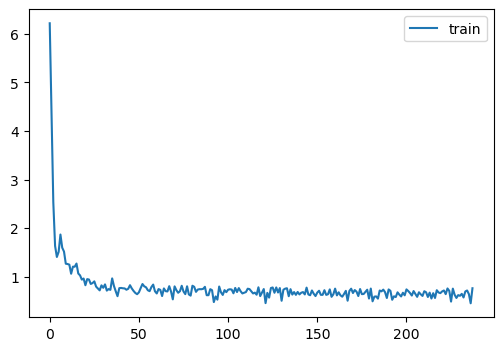

In [39]:
learn.fit(1, cbs=prog)

loss,epoch,train
0.655,0,train
0.636,0,eval


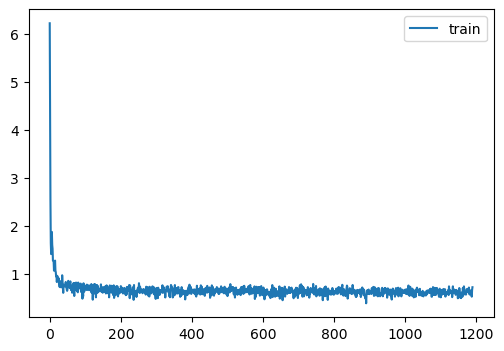

In [39]:
learn.fit(1, cbs=prog)

In [43]:
learn.model.save_pretrained('sql_1ep_636')

In [48]:
#SGD
torch.cuda.max_memory_allocated()/1_000_000_000

23.791612928

In [48]:
#mom
torch.cuda.max_memory_allocated()/1_000_000_000

24.445877248

In [49]:
#adam
torch.cuda.max_memory_allocated()/1_000_000_000

44.16957184

In [50]:
# learn.lr_find(max_mult=10)

# Testing

In [40]:
prompt = "Context:" + eval_dataset[0]['context'] + "\nQuestion:" + eval_dataset[0]['question'] + "\nAnswer:"
tokenized_prompt = tokenizer(prompt, return_tensors='pt')['input_ids'].cuda()

In [41]:
with torch.inference_mode():
    output = model.generate(tokenized_prompt, max_new_tokens=90)

In [42]:
print(prompt + tokenizer.decode(output[0][len(tokenized_prompt[0]):], skip_special_tokens=True))

Context:CREATE TABLE table_name_95 (tournament VARCHAR, score VARCHAR, outcome VARCHAR, surface VARCHAR)
Question:Which tournament has an Outcome of runner-up, a Surface of hard, and a Score of 6–4, 6–2?
Answer:SELECT tournament FROM table_name_95 WHERE outcome = "runner-up" AND surface = "hard" AND score = "6–4, 6–2"


In [ ]:
llama_base = AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    low_cpu_mem_usage=True,
    torch_dtype=torch.bfloat16,
    use_cache=False
)

ds = eval_dataset.map(tok, batched=True)
ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
ds = ds.remove_columns(['context', 'answer', 'question', 'text'])
dl = torch.utils.data.DataLoader(ds, batch_size=8)

llama_base.model.embed_tokens.weight.requires_grad_(False);

b = next(iter(dl))
llama_base = llama_base.cuda().train()
llama_base.gradient_checkpointing_enable()
r = llama_base(**to_device(b))

loss = lf(r.logits.view(-1,32000), b['input_ids'].view(-1).cuda())
loss.backward()

loss

llama_base.model.layers[9].mlp.gate_proj.weight.grad